In [1]:
import requests
import cv2
import sys
import warnings

import scholarly as slr
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np

from PIL import Image
from io import BytesIO
from networkx.drawing.nx_pydot import write_dot

# warnings.filterwarnings('ignore')

%matplotlib inline

In [2]:
class ImageToFace:
    def __init__(self):
        # Model parameters
        dir_path = "/usr/local/Cellar/opencv/2.4.13.2/share/OpenCV/haarcascades"
        filename = "haarcascade_frontalface_default.xml" # for frontal faces
        #filename = "haarcascade_profileface.xml" # for profile faces
        model_path = dir_path + "/" + filename

        # Create the classifier
        self.clf = cv2.CascadeClassifier(model_path)
        
    def get_face(self, img):
        image = np.array(img.convert('RGB'))[:,:,::-1]
        gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

        # Detect faces on image
        faces = self.clf.detectMultiScale(
            gray,
            scaleFactor=1.1,
            minNeighbors=5,
            minSize=(30, 30),
            flags=cv2.CASCADE_SCALE_IMAGE
        )
        
        if len(faces) > 0:
            x, y, w, h = faces[0]
        else:
            return img
        
        return Image.fromarray(cv2.cvtColor(image[y:y+h, x:x+w], cv2.COLOR_BGR2RGB))
    
imtf = ImageToFace()

get_face = imtf.get_face

In [3]:
class FakeInfo:
    def __init__(self, name):
        self.name = name
        self.id = hash(name)
        self.url_picture = '/citations/images/avatar_scholar_128.jpg'
        self.publications = []

In [4]:
class GoogleNetwork:
    def __init__(self):
        self.site_prefix = 'https://scholar.google.com'
        self.id_info = {}
        self.name_id = {}
    
    def possible_names(self, author_name):
        full_name = author_name.split(' ')
        name, middle_names, surname = full_name[0], full_name[1:-1], full_name[-1]
        
        result = [name + ' ' + surname, name[0] + ' ' + surname, name[0] + '. ' + surname]
        
        if len(middle_names) > 0:
            result += [
                name + ' ' + ' '.join(middle_names) + ' ' + surname,
                name + ' ' + ''.join([mn[0] for mn in middle_names]) + ' ' + surname,
                name + ' ' + '. '.join([mn[0] for mn in middle_names]) + '. ' + surname,
                name[0] + ''.join([mn[0] for mn in middle_names]) + ' ' + surname,
                name[0] + '. ' + '. '.join([mn[0] for mn in middle_names]) + '. ' + surname                
            ]
        
        return result
    
    def get_info(self, author_name):
        if author_name in self.name_id:
            print('\t {} is already in the database.'.format(author_name))
            return self.id_info[self.name_id[author_name]]
        else:
            try:
                print('\t Searching {} in google scholar.'.format(author_name))
                author_info = next(slr.search_author(author_name)).fill()
            except:
                print('\t \t No match, creating fake id.')
                author_info = FakeInfo(author_name)
                
            print('\t Adding {} in database.'.format(author_name))
                
            self.id_info[author_info.id] = author_info
            
            for name in self.possible_names(author_name) + self.possible_names(author_info.name):
                self.name_id[name] = author_info.id
                
            return author_info
        
    def add_author(self, G, author_name):
        print('Adding {}:'.format(author_name))
        
        author_info = self.get_info(author_name)
        
        if author_info.id in G.nodes():
            print('\t Author id is already in the network.')            
            return
        
        print('\t Adding {} to network.'.format(author_name))
        G.add_node(author_info.id)
        
        response = requests.get(self.site_prefix + author_info.url_picture)
        img = Image.open(BytesIO(response.content))
        G.node[author_info.id]['image'] = get_face(img)
                
    def add_coauthors(self, G, author_name):
        print("Adding {}'s co-authors:".format(author_name))
        author_info = self.id_info[self.name_id[author_name]]
        author_id = author_info.id
        
        G.node[author_id]['co-authors'] = set()
        
        for pub in author_info.publications:
            pub.fill()
            union = G.node[author_id]['co-authors'].union(pub.bib['author'].split(' and '))
            G.node[author_id]['co-authors'] = union
            
        for coauthor_name in G.node[author_id]['co-authors']:
            coauthor_info = self.get_info(coauthor_name)
            
            if coauthor_info.id != author_id:
                self.add_author(G, coauthor_info.name)
                print('\t Addind connection between {a} and {c}.\n'.format(a=author_name, c=coauthor_name))
                G.add_edge(author_id, coauthor_info.id)

In [5]:
G = nx.Graph()

In [6]:
gn = GoogleNetwork()

In [7]:
gn.add_author(G, 'Arseny Alexeev')

Adding Arseny Alexeev:
	 Searching Arseny Alexeev in google scholar.
	 Adding Arseny Alexeev in database.
	 Adding Arseny Alexeev to network.


In [8]:
gn.add_coauthors(G, 'Arseny Alexeev')

Adding Arseny Alexeev's co-authors:
	 Searching Evangelos Eleftheriou in google scholar.
	 Adding Evangelos Eleftheriou in database.
Adding Evangelos Eleftheriou:
	 Evangelos Eleftheriou is already in the database.
	 Adding Evangelos Eleftheriou to network.
	 Addind connection between Arseny Alexeev and Evangelos Eleftheriou.

	 Searching Khue T Lai in google scholar.
	 	 No match, creating fake id.
	 Adding Khue T Lai in database.
Adding Khue T Lai:
	 Khue T Lai is already in the database.
	 Adding Khue T Lai to network.
	 Addind connection between Arseny Alexeev and Khue T Lai.

	 Searching TA Bachmann in google scholar.
	 	 No match, creating fake id.
	 Adding TA Bachmann in database.
Adding TA Bachmann:
	 TA Bachmann is already in the database.
	 Adding TA Bachmann to network.
	 Addind connection between Arseny Alexeev and TA Bachmann.

	 Searching Matthew D Barnes in google scholar.
	 Adding Matthew D Barnes in database.
Adding Matthew D. Barnes:
	 Matthew D. Barnes is already in 

	 Adding Abu Sebastian in database.
Adding Abu Sebastian:
	 Abu Sebastian is already in the database.
	 Adding Abu Sebastian to network.
	 Addind connection between Arseny Alexeev and Abu Sebastian.

	 A Sebastian is already in the database.
Adding Abu Sebastian:
	 Abu Sebastian is already in the database.
	 Author id is already in the network.
	 Addind connection between Arseny Alexeev and A Sebastian.

	 AM Alexeev is already in the database.
	 Searching S Zhang in google scholar.
	 Adding S Zhang in database.
Adding Shou-Cheng Zhang:
	 Shou-Cheng Zhang is already in the database.
	 Adding Shou-Cheng Zhang to network.
	 Addind connection between Arseny Alexeev and S Zhang.

	 Monica F Craciun is already in the database.
Adding Monica Felicia Craciun:
	 Monica Felicia Craciun is already in the database.
	 Author id is already in the network.
	 Addind connection between Arseny Alexeev and Monica F Craciun.

	 Searching C Scheu in google scholar.
	 Adding C Scheu in database.
Adding Chr

In [11]:
for i in G[gn.name_id['A Alexeev']]:
    print(gn.id_info[i].name)

Evangelos Eleftheriou
Khue T Lai
TA Bachmann
Matthew D. Barnes
Richard E. Hartman
Charles D. Wright
Venkata Karthik Nagareddy
Wabe W. Koelmans
Mikhail E Portnoi
Matthias Wuttig
O Cojocaru-Mirédin
Alessandro Curioni
Monica Felicia Craciun
V Karthik Nagareddy
Tobias Bachmann
Federico Zipoli
IA Shelykh
Andrea C. Ferrari
Prasad Jonnalagadda
David Charles Wright Carr
Anne Broadbent
VP Jonnalagadda
Chang Dou
Abu Sebastian
Shou-Cheng Zhang
Christina Scheu
Chunmeng Duo
AK Ott


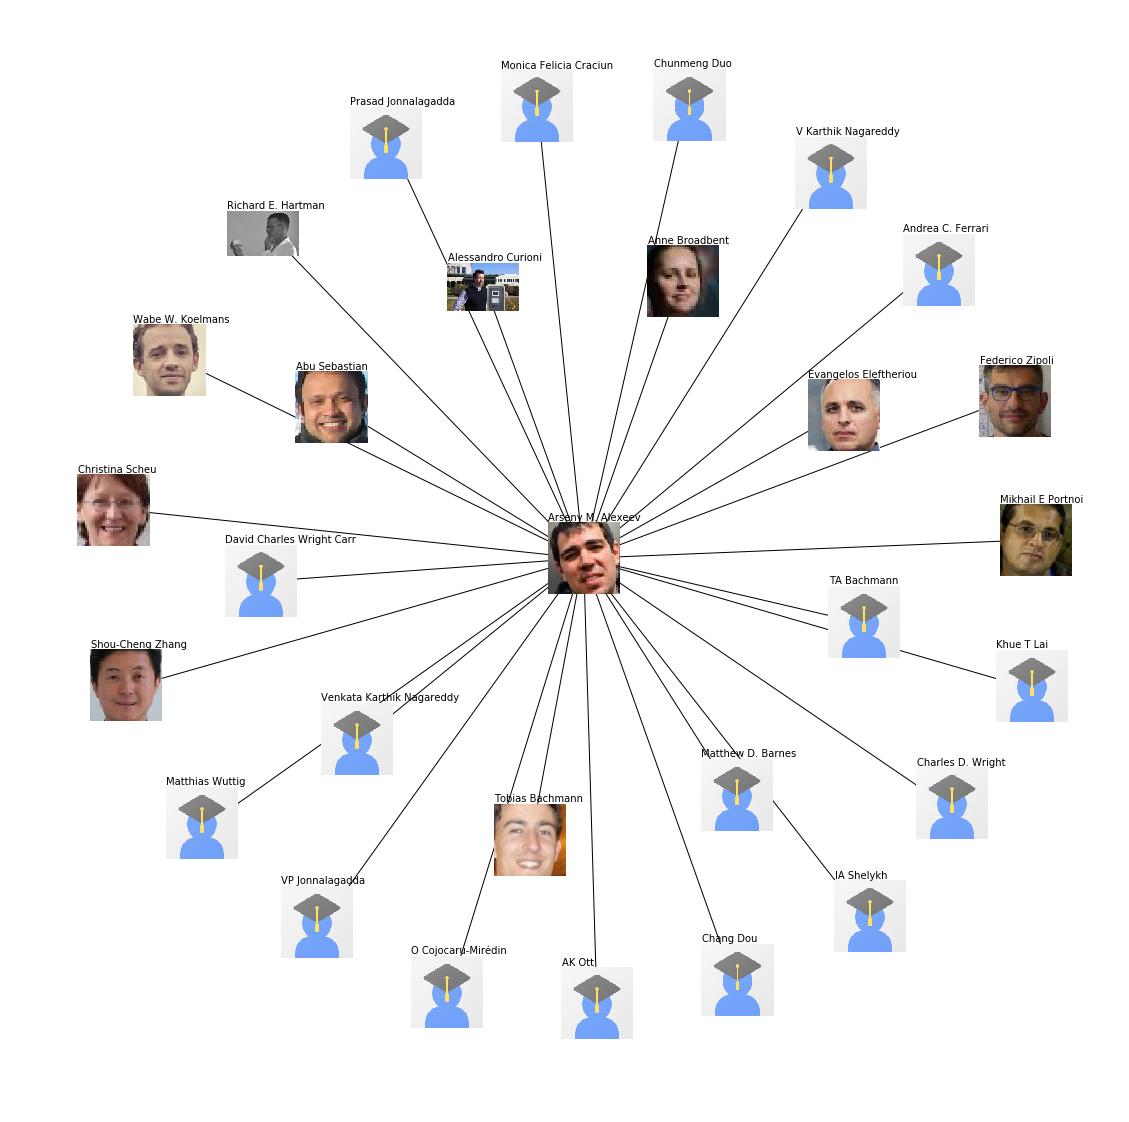

In [19]:
pos = nx.spring_layout(G)
fig = plt.figure(figsize=(20,20))
ax = plt.subplot(111)
ax.set_aspect('equal')
nx.draw_networkx_edges(G, pos, ax=ax)

plt.axis('off')

trans = ax.transData.transform
trans2 = fig.transFigure.inverted().transform

piesize = 0.05 # this is the image size
p2 = piesize / 2.0
for n in G:
    xx, yy = trans(pos[n]) # figure coordinates
    xa, ya = trans2((xx, yy)) # axes coordinates
    a = plt.axes([xa - p2, ya - p2, piesize, piesize])
    a.set_aspect('equal')
    a.imshow(G.node[n]['image'])
    a.annotate(gn.id_info[n].name, xy=(0, 0), horizontalalignment='left', verticalalignment='bottom')
    a.axis('off')
    
plt.savefig('google-scholar-first-circle')